In [297]:
from scipy.optimize import minimize
import numpy as np
from typing import List
from matplotlib import pyplot as plt

NUM_DEGREES = 4

In [333]:
def to_hsl(matrix: np.ndarray, rgb: np.ndarray) -> np.ndarray:
    assert rgb.shape == (3,)
    assert matrix.shape == (3,3)
    ycbcr = matrix @ rgb.T

    hsl = np.zeros(3)
    hsl[2] = ycbcr[0]
    hsl[0] = np.arctan2(ycbcr[2], ycbcr[1])
    hsl[1] = np.sqrt(ycbcr[1]**2 + ycbcr[2]**2)
    return hsl

def to_rgb(matrix: np.ndarray, hsl: np.ndarray) -> np.ndarray:
    assert hsl.shape == (3,)
    assert matrix.shape == (3,3)
    ycbcr = np.zeros(3)
    ycbcr[0] = hsl[2]
    ycbcr[1] = hsl[1] * np.cos(hsl[0])
    ycbcr[2] = hsl[1] * np.sin(hsl[0])
    rgb = np.linalg.inv(matrix) @ ycbcr
    return rgb


def get_rgb_to_ycbcr_mat(lum_coeffs: np.ndarray) -> np.ndarray:
    dest = np.zeros((3, 3))
    dest[0][0] = lum_coeffs[0]
    dest[0][1] = lum_coeffs[1]
    dest[0][2] = lum_coeffs[2]
    dest[1][0] = -0.5 * (lum_coeffs[0] / (1.0 - lum_coeffs[2]))
    dest[1][1] = -0.5 * (lum_coeffs[1] / (1.0 - lum_coeffs[2]))
    dest[1][2] = 0.5
    dest[2][0] = 0.5
    dest[2][1] = -0.5 * (lum_coeffs[1] / (1.0 - lum_coeffs[0]))
    dest[2][2] = -0.5 * (lum_coeffs[2] / (1.0 - lum_coeffs[0]))
    return dest

def get_matrix(degrees: List[float]) -> np.ndarray:
    assert len(degrees) == NUM_DEGREES
    matrix = get_rgb_to_ycbcr_mat(np.array([0.2126, 0.7152, 0.0722]))
    inv_matrix = np.linalg.inv(matrix)
    axis1 = inv_matrix[:, 1]
    axis2 = inv_matrix[:, 2]

    axes = np.array([axis1, axis2])

    assert axes.shape == (2, 3)
    scaling = np.array([
        [degrees[0], degrees[1]],
        [degrees[2], degrees[3]],
    ])
    assert scaling.shape == (2, 2)
    new_axes = scaling @ axes
    inv_matrix[:, 1] = new_axes[0]
    inv_matrix[:, 2] = new_axes[1]
    matrix = np.linalg.inv(inv_matrix)
    return matrix


def get_full_matrix(degrees: List[float]) -> np.ndarray:
    assert len(degrees) == 6
    matrix = get_rgb_to_ycbcr_mat(np.array([0.2126, 0.7152, 0.0722]))
    matrix[1][0] = degrees[0]
    matrix[1][1] = degrees[1]
    matrix[1][2] = degrees[2]
    matrix[2][0] = degrees[3]
    matrix[2][1] = degrees[4]
    matrix[2][2] = degrees[5]
    return matrix


def forward(degrees: List[float], rgb: np.ndarray, known_rotation: float) -> np.ndarray:
    assert rgb.shape == (3,)
    assert np.array(degrees).shape == (NUM_DEGREES,)
    matrix = get_matrix(degrees)
    hsl = to_hsl(matrix, rgb)
    hsl[0] += known_rotation
    new_rgb = to_rgb(matrix, hsl)
    return new_rgb

def forward_bulk(degrees: List[float], rgb: np.ndarray, known_rotation: float) -> np.ndarray:
    n, c = rgb.shape
    rgb_out = np.zeros_like(rgb)
    for i in range(n):
        rgb_out[i] = forward(degrees, rgb[i], known_rotation)
    return rgb_out

def loss(degrees: List[float], rgb_in: np.ndarray, rgb_out: np.ndarray, known_rotation: float) -> float:
    n, c = rgb_in.shape

    assert c == 3
    assert rgb_out.shape == rgb_in.shape

    # Error coefficients
    rgb_pred = forward_bulk(degrees, rgb_in, known_rotation)
    l = np.sum((rgb_out - rgb_pred) ** 2) / n

    # scaling shit
    red = np.array([1.0, 0.0, 0.0])
    hsl = to_hsl(get_matrix(degrees), red)

    l += hsl[0]**2 # red should be at zero.
    l += (hsl[1] - 1.0)**2

    return l

def regression_matrix(rgb_in: np.ndarray, rgb_out: np.ndarray, known_rotation: float) -> np.ndarray:
    final_loss = 100.0
    while final_loss > 0.0001:
        init_degrees = np.random.rand(NUM_DEGREES)
        init_degrees /= init_degrees.sum()
        # init_degrees = np.array([2.0, 0.0, 0.0])
        print("Initial loss: ", loss(init_degrees, rgb_in, rgb_out, known_rotation))
        result = minimize(loss, init_degrees, args=(rgb_in, rgb_out, known_rotation), method='L-BFGS-B', bounds=[(-2.0, 2.0)] * NUM_DEGREES)
        output_matrix = get_matrix(result.x)
        final_loss = loss(result.x, rgb_in, rgb_out, known_rotation)
        print("final loss: ", final_loss)
    return output_matrix, result.x



In [334]:
# forward([1.0, 0.0, 0.0], np.array([1.0, 0.5, 0.0]), 60 * np.pi / 180)

In [335]:
import os

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2  # type:ignore
import numpy as np
from typing import Tuple, List, Union


def open_image(image_fn: str) -> np.ndarray:
    print(f"Reading: {image_fn}")
    os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
    img: np.ndarray = cv2.imread(image_fn, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    print(f"Read image data type of {img.dtype}")
    if img.dtype == np.uint8 or img.dtype == np.uint16:
        img = img.astype(np.float32) / np.iinfo(img.dtype).max
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [336]:
source_image = open_image("/Users/thatcher/Desktop/sat1x_0000.exr")
target_image = open_image("/Users/thatcher/Desktop/hue_60deg_0000.exr")
expected_rot_deg = 60

# source_image = open_image("/Users/thatcher/Desktop/synthetic/source0000.exr")
# target_image = open_image("/Users/thatcher/Desktop/synthetic/rot_30deg_0000.exr")
# expected_rot_deg = 30

Reading: /Users/thatcher/Desktop/sat1x_0000.exr
Read image data type of float32
Reading: /Users/thatcher/Desktop/hue_60deg_0000.exr
Read image data type of float32


(array([ 1.,  0.,  0.,  0.,  1.,  1.,  3.,  2.,  1.,  4.,  3.,  1.,  4.,
         4.,  5.,  2.,  5.,  5.,  5.,  5.,  6.,  3.,  6.,  6., 10.,  5.,
         5.,  7.,  2.,  4.,  8.,  9.,  4.,  6.,  7.,  4.,  6.,  6.,  6.,
         7.,  7.,  9.,  3., 11.,  6.,  1.,  7.,  8., 12.,  9., 10.,  9.,
        11.,  5.,  4.,  9.,  3.,  8.,  9.,  8.,  6.,  8.,  7.,  6., 14.,
         5.,  6.,  8.,  9.,  8.,  4.,  5., 10.,  5.,  8., 10.,  3.,  4.,
         1.,  3.,  7.,  9.,  7.,  1.,  5.,  3.,  0.,  5.,  3.,  3.,  1.,
         2.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  2.]),
 array([-0.14406283, -0.13109675, -0.11813067, -0.10516458, -0.0921985 ,
        -0.07923242, -0.06626634, -0.05330025, -0.04033417, -0.02736809,
        -0.014402  , -0.00143592,  0.01153016,  0.02449624,  0.03746233,
         0.05042841,  0.06339449,  0.07636058,  0.08932666,  0.10229274,
         0.11525883,  0.12822491,  0.14119099,  0.15415707,  0.16712315,
         0.18008924,  0.19305532,  0.2060214 ,  0.21898749,  0.231953

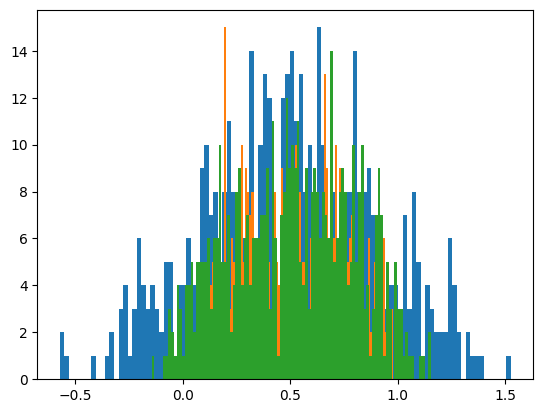

In [337]:
assert source_image.shape == target_image.shape
h, w, c = source_image.shape
source_image_flat = source_image.reshape(h * w, c)
target_image_flat = target_image.reshape(h * w, c)

n_samples = 500

idxs = np.random.choice(source_image_flat.shape[0], n_samples, replace=False)
source_samples = source_image_flat[idxs]
target_samples = target_image_flat[idxs]
plt.hist(target_samples[:, 0], bins=100)
plt.hist(target_samples[:, 1], bins=100)
plt.hist(target_samples[:, 2], bins=100)

In [338]:
result_matrix, degs = regression_matrix(
    source_samples,
    target_samples,
    expected_rot_deg * np.pi / 180.0
)
print(result_matrix)
print(np.linalg.inv(result_matrix))

Initial loss:  60.56313811319803
final loss:  4.066720439139567
Initial loss:  307.1189561524215
final loss:  4.171933854391804
Initial loss:  8.628396273659542
final loss:  0.8086415585102336
Initial loss:  0.7026060663176095
final loss:  8.534023774231554e-06
[[ 2.12600000e-01  7.15200000e-01  7.22000000e-02]
 [ 9.99949644e-01 -4.98010356e-01 -5.01939288e-01]
 [ 6.77416124e-05 -8.66634150e-01  8.66566409e-01]]
[[ 1.          0.7874144   0.37277492]
 [ 1.         -0.21259672 -0.20645924]
 [ 1.         -0.21267489  0.94747512]]


In [ ]:
print(degs)

[ 0.15685778  0.45884456  0.4097951  -0.06671684]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7139517..1.7139517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7152443..1.7141259].


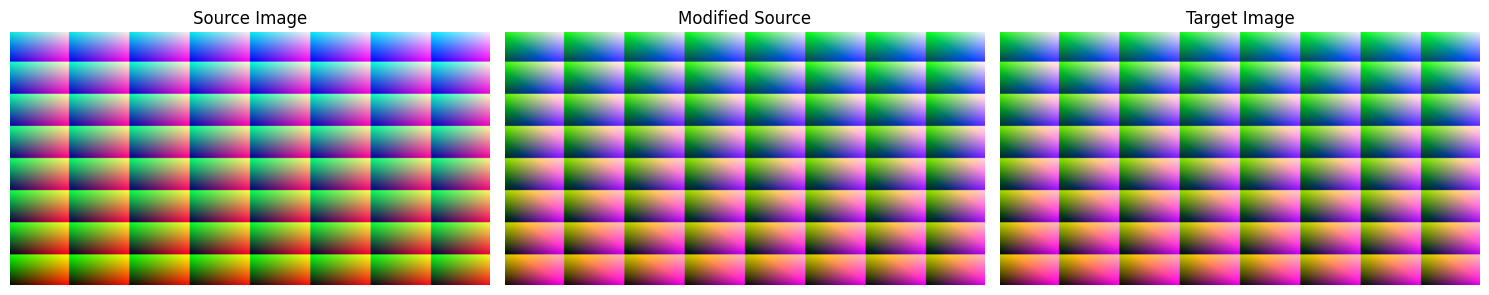

In [ ]:
modified_source = forward_bulk(degs, source_image_flat, expected_rot_deg * np.pi / 180.0)
modified_source = modified_source.reshape(h, w, c)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(source_image)
axes[0].set_title("Source Image")
axes[1].imshow(modified_source)
axes[1].set_title("Modified Source")
axes[2].imshow(target_image)
axes[2].set_title("Target Image")
for ax in axes:
    ax.axis("off")
plt.tight_layout()